# Feature Engineering and Time Series Feature Generation

### 08th Februry 2022 created by Yan Ge


In this Notebook, we will focus on:1) Time-series feature generation; 2) Feature generation with machine learning: case study of financial marketing with recommender systems

Sources of this tutorial: 1). https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/; 2) https://github.com/Apress/hands-on-time-series-analylsis-python

# Time Series Feature Generation

In this part, we will use a daily stock price of Apple.Inc (one year: from 28/Dec/2020 to 27/Dec/2021), which is derived from Yahoo Finance. First, the time series is loaded as a Pandas Series. We then create a new Pandas DataFrame for the transformed dataset. Next, each column is added one at a time where month and day information is extracted from the time-stamp information for each observation in the series. Below is the Python code to do this.

In [1]:
# create date time features of a dataset
from pandas import read_csv
from pandas import DataFrame
series = read_csv('data/AAPL.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
dataframe = DataFrame()
dataframe['month'] = [series.index[i].month for i in range(len(series))]
dataframe['day'] = [series.index[i].day for i in range(len(series))]
dataframe['price'] = [series[i] for i in range(len(series))]
print(dataframe.head(15))

    month  day       price
0      12   28  133.990005
1      12   29  138.050003
2      12   30  135.580002
3      12   31  134.080002
4       4    1  133.520004
5       5    1  128.889999
6       6    1  127.720001
7       7    1  128.360001
8       8    1  132.429993
9      11    1  129.190002
10     12    1  128.500000
11      1   13  128.759995
12      1   14  130.800003
13      1   15  128.779999
14      1   19  127.779999


### Lag feature

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the previous time (t-1). The supervised learning problem with shifted values looks as follows:

Value(t-1), Value(t+1)

Value(t-1), Value(t+1)

Value(t-1), Value(t+1)

The Pandas library provides the shift() function to help create these shifted or lag features from a time series dataset. Note that: in this tutorial, shifting the dataset by 1 creates the t-1 column, adding a NaN (unknown) value for the first row. The time series dataset without a shift represents the t+1

Below is an example of creating a lag feature for our daily stock price dataset. The values are extracted from the loaded series and a shifted and unshifted list of these values is created. Each column is also named in the DataFrame for clarity.

In [2]:
import pandas as pd
series = read_csv('data/AAPL.csv', header=0, index_col=0)
df = pd.DataFrame()

df['t'] = series['Open'].values
df['t-1'] = df['t'].shift(1)
df['t-2'] = df['t'].shift(2)
df['t-3'] = df['t'].shift(3)

df.head(5)

,t,t-1,t-2,t-3
0,133.990005,NaN,NaN,NaN
1,138.050003,133.990005,NaN,NaN
2,135.580002,138.050003,133.990005,NaN
3,134.080002,135.580002,138.050003,133.990005
4,133.520004,134.080002,135.580002,138.050003


In [3]:
# shift operation with 1 lag

In [4]:

df = df[['t-3', 't-2', 't-1', 't']]

df = df[3:]

print(df.head(5))

          t-3         t-2         t-1           t
3  133.990005  138.050003  135.580002  134.080002
4  138.050003  135.580002  134.080002  133.520004
5  135.580002  134.080002  133.520004  128.889999
6  134.080002  133.520004  128.889999  127.720001
7  133.520004  128.889999  127.720001  128.360001


You can see that we would have to discard the first row to use the dataset to train a supervised learning model, as it does not contain enough data to work with.

The addition of lag features is called the sliding window method, in this case with a window width of 1. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width.

We can expand the window width and include more lagged features. For example, below is the above case modified to include the last 3 observed values to predict the value at the next time step.

Again, you can see that we must discard the first few rows that do not have enough data to train a supervised model. A difficulty with the sliding window approach is how large to make the window for your problem. Perhaps a good starting point is to perform a sensitivity analysis and try a suite of different window widths to in turn create a suite of different “views” of your dataset and see which results in better performing models. 

### Rolling Window Statistics

A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous few values, also called the rolling mean. For example, we can calculate the mean of the previous two values and use that to predict the next value. 

The first thing we need to do is shifted. Then the rolling dataset can be created and the mean values calculated on each window of two values.

In [5]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('data/AAPL.csv', header=0, index_col=0)
temps = DataFrame(series.values)
shifted = temps.shift(1)

window = shifted.rolling(window=5)
means = window.mean()

df = concat([means, temps], axis=1)
df.columns = ['5 day moving', 't+1']

df.head(10)

,5 day moving,t+1
0,NaN,133.990005
1,NaN,138.050003
2,NaN,135.580002
3,NaN,134.080002
4,NaN,133.520004
5,135.044003,128.889999
6,134.024002,127.720001
7,131.958002,128.360001
8,130.514001,132.429993
9,130.184000,129.190002


### Expanding Window Statistics

In [6]:

window = temps.expanding()

df['max'] = window.max()
df['min'] = window.min()
df['mean'] = window.mean()

df.head(10)


,5 day moving,t+1,max,min,mean
0,NaN,133.990005,133.990005,133.990005,133.990005
1,NaN,138.050003,138.050003,133.990005,136.020004
2,NaN,135.580002,138.050003,133.990005,135.873337
3,NaN,134.080002,138.050003,133.990005,135.425003
4,NaN,133.520004,138.050003,133.520004,135.044003
5,135.044003,128.889999,138.050003,128.889999,134.018336
6,134.024002,127.720001,138.050003,127.720001,133.118574
7,131.958002,128.360001,138.050003,127.720001,132.523752
8,130.514001,132.429993,138.050003,127.720001,132.513334
9,130.184000,129.190002,138.050003,127.720001,132.181001


 # Feature generation with machine learning: case study of financial marketing with recommender systems

In this part, we use a real-world dataset from Amazon.com.Inc. In total, this dataset includes 478,235 users and 266,414 items. The data is from http://jmcauley.ucsd.edu/data/amazon/.

In [7]:
import numpy as np
import pandas as pd

In [8]:
# In this example, we only use 12,000 user-item pairs. But you can break this limitation by using the whole dataset.
df=pd.read_csv('data/ratings_Digital_Music.csv',header=None, nrows=12000)
df.head() #column order: user, items, ratings, timestamp

,0,1,2,3
0,A2EFCYXHNK06IS,5555991584,5.0,978480000
1,A1WR23ER5HMAA9,5555991584,5.0,953424000
2,A2IR4Q0GPAFJKW,5555991584,4.0,1393545600
3,A2V0KUVAB9HSYO,5555991584,4.0,966124800
4,A1J0GL9HCA7ELW,5555991584,5.0,1007683200


In [9]:
df.shape

(12000, 4)

In [10]:
n_users = df[0].unique().shape[0]
n_items = df[1].unique().shape[0]
n_rating = df[2].unique().shape[0]

print ('%i unique users' %n_users)
print ('%i unique items' %n_items)
print ('%i unique ratings' %n_rating)

9843 unique users
561 unique items
5 unique ratings


In [11]:
# generate user-item matrix
ratings=df.pivot(index=0, columns=1, values=2)

In [12]:
# fill NaN values with 0

ratings=ratings.fillna(0).values

print(ratings)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
# make a statistical analysis about the percetage of exsiting user-items ratings. From this statistics, we can see that 
# the vast majority of ratings are missing, which is our motivation to develop a recommender system to predict such missing values

sparsity = float(len(ratings.nonzero()[0]))

print(str(100*sparsity/(ratings.shape[0]*ratings.shape[1])) + " %")

0.217315598207 %


In [14]:
# This creats a validation dataset by selecting rows (user) that have 35 or more ratings, then randomly select 15 of those ratings
#for validation set, but set those values to 0 in the training set.

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy() #don't do train=ratings, otherwise, ratings becomes empty
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0])>=35:# 35 seems to be best, it depends on sparsity of your user-item matrix
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=15, #tweak this, 15 seems to be optimal
                                        replace=False)
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    print(validation.shape)
    return train, validation

In [15]:
# split this dataset into train and test sets

train, val = train_test_split(ratings)

(9843L, 561L)


In [16]:
#P is latent user feature matrix
#Q is latent item feature matrix
# make a rating prediction given P and Q

def prediction(P,Q):
    return np.dot(P.T,Q)
    

In [24]:
lmbda = 0.4 # Regularization parameter
k = 3 #tweak this parameter
m, n = train.shape  # Number of users and items
n_epochs = 30  # Number of epochs
alpha=0.05  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [32]:
train_errors = []
val_errors = []
# Gradient descent for optimisation
# Only consider items with ratings 
users,items = train.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
        P[:,u] += alpha * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += alpha * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent item feature matrix
    
    train_rmse = rmse(prediction(P,Q),train)
    val_rmse = rmse(prediction(P,Q),val) 
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

[[0.79921692 0.82436425 0.84699491 ... 0.59317021 1.27416027 0.84872295]
 [3.80549746 4.39436079 3.62396741 ... 4.31092025 2.86076869 3.67278223]
 [4.67470597 5.26672802 4.54836881 ... 5.30181246 4.10379699 4.51956649]
 ...
 [5.23242708 5.88972048 5.10934156 ... 5.59451865 4.86547025 5.13579582]
 [4.25502932 4.69380133 4.22828496 ... 4.48562224 4.43629355 4.1976268 ]
 [4.69582402 5.33679242 4.5372352  ... 5.26749326 3.95550825 4.54984947]]
[[0.80120943 0.8129841  0.84806044 ... 0.60456187 1.263766   0.84875831]
 [3.79388753 4.35299184 3.61527339 ... 4.2698062  2.86703104 3.6638038 ]
 [4.67034612 5.22753833 4.54420395 ... 5.26477207 4.10581697 4.51797712]
 ...
 [5.23186809 5.84273518 5.109254   ... 5.57261624 4.86259173 5.13564414]
 [4.2291038  4.62378694 4.20286308 ... 4.43983889 4.41110013 4.1732796 ]
 [4.6945515  5.29914675 4.53744882 ... 5.23486357 3.96538877 4.55102339]]
[[0.80316199 0.80276812 0.8490918  ... 0.61547568 1.25380486 0.8488945 ]
 [3.78351506 4.31482352 3.60756721 ... 

[[0.83251082 0.73785557 0.86353774 ... 0.74397087 1.13123209 0.85868794]
 [3.71791638 3.95687556 3.56396361 ... 3.87268553 3.01518705 3.60851449]
 [4.62265326 4.81306708 4.49582732 ... 4.84883992 4.13848619 4.49739135]
 ...
 [5.1942924  5.35427069 5.06126931 ... 5.30249379 4.76596603 5.09323658]
 [3.91918094 3.87835828 3.89978375 ... 3.93372721 4.12677624 3.88405735]
 [4.67226047 4.88516352 4.52709339 ... 4.86205183 4.09209355 4.55038902]]
[[0.83427313 0.73793705 0.86448935 ... 0.74921388 1.12617294 0.85963185]
 [3.71736459 3.94577264 3.56409813 ... 3.86206433 3.02339743 3.60842381]
 [4.62106927 4.80014316 4.49411477 ... 4.83517657 4.13986441 4.49665465]
 ...
 [5.19066    5.33890015 5.05658987 ... 5.29154584 4.75807543 5.08894715]
 [3.90819348 3.85490746 3.88911142 ... 3.91731584 4.11735229 3.8739087 ]
 [4.6716344  4.87208351 4.52678352 ... 4.85018224 4.09752506 4.55035508]]
[[0.8360411  0.73825729 0.86545813 ... 0.75427775 1.12129273 0.86060192]
 [3.71695624 3.93529776 3.56436194 ... 

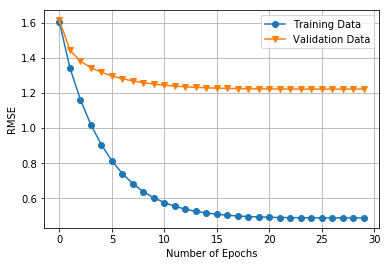

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

### Take a look at prediction vs. actual ratings

In [29]:
SGD_prediction=prediction(P,Q)

In [30]:
estimation= SGD_prediction[val.nonzero()]
ground_truth = val[val.nonzero()]
results=pd.DataFrame({'prediction':estimation, 'actual rating':ground_truth})

In [31]:
results.head()

,actual rating,prediction
0,5.0,3.866720
1,5.0,3.158955
2,4.0,3.884421
3,5.0,3.796777
4,5.0,3.663012
